In [1]:
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import cv2## image processing
import os## operating system
import random
import copy
from google.colab import files
import torch, torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
! pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 665M/675M [00:10<00:00, 26.2MB/s]
100% 675M/675M [00:10<00:00, 66.7MB/s]


In [7]:
!unzip /content/cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [8]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('cell_images/Parasitized')
train_paths_parasitized = ['cell_images/Parasitized/' + i for i in train_paths_parasitized]

train_paths_uninfected += os.listdir('cell_images/Uninfected')
train_paths_uninfected = ['cell_images/Uninfected/' + i for i in train_paths_uninfected]

paths = train_paths_parasitized + train_paths_uninfected

paths.remove("cell_images/Parasitized/Thumbs.db")
paths.remove("cell_images/Uninfected/Thumbs.db")

random.shuffle(paths)

FRACTION = 0.8
train_paths = paths[0:int(FRACTION*len(paths))]
val_paths = paths[int(FRACTION*len(paths)):]
print(len(val_paths), len(train_paths))

5512 22046


In [9]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[1] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0


    if self.transform:
      image = self.transform(image = image)['image']

    return image, label


In [10]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [11]:
IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3),

                        A.RandomRotate90(),
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),
                        A.Normalize(),


])

In [12]:
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)

In [13]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [14]:
image, label = next(iter(train_loader))
print(image[2][100:150,100:150,0])

tensor([[1.7352, 1.7352, 1.7180,  ..., 1.7352, 1.7352, 1.7352],
        [1.7180, 1.7180, 1.7352,  ..., 1.7694, 1.7694, 1.7352],
        [1.7180, 1.7352, 1.7352,  ..., 1.8037, 1.7694, 1.7352],
        ...,
        [1.8550, 1.8379, 1.8379,  ..., 1.7352, 1.7180, 1.7180],
        [1.8379, 1.8379, 1.8379,  ..., 1.7352, 1.7180, 1.7180],
        [1.8379, 1.8379, 1.8379,  ..., 1.7352, 1.7352, 1.7180]])


tensor(1., dtype=torch.float64)


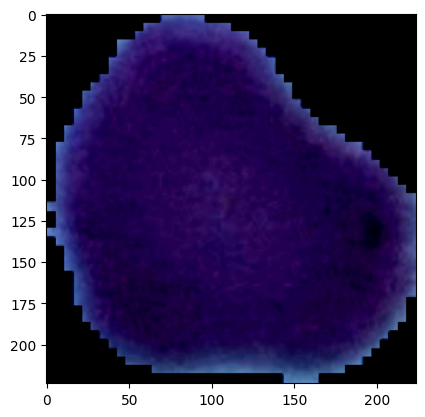

In [15]:
plt.imshow(image[0])
print(label[0])

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Depthwise Separable Convolution blocks
        self.block1 = self._make_block(32, 64, stride=1)
        self.block2 = self._make_block(64, 128, stride=2)
        self.block3 = self._make_block(128, 128, stride=1)
        self.block4 = self._make_block(128, 256, stride=2)
        self.block5 = self._make_block(256, 256, stride=1)
        self.block6 = self._make_block(256, 512, stride=2)
        self.block7 = self._make_block(512, 512, stride=1)
        self.block8 = self._make_block(512, 1024, stride=2)
        self.block9 = self._make_block(1024, 1024, stride=1)

        # Fully connected layers
        self.fc = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 1)  # Final layer for binary classification

    def _make_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Initial convolution layer
        x = F.relu(self.bn1(self.conv1(x)))

        # Sequential blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)

        # Global average pooling (2D -> 1D)
        x = x.mean([2, 3])  # This reduces the spatial dimensions (H, W) to a single value

        # Fully connected layers
        x = F.relu(self.fc(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification

        return x


# Example usage:
model = MobileNet()
print(model(torch.zeros((1, 3, 224, 224))))  # Testing with an input tensor of shape (batch_size, channels, height, width)


tensor([[0.5113]], grad_fn=<SigmoidBackward0>)


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3, )

In [29]:
print(device)

cuda:0


In [30]:
def round(x):
  if(x>= 0.5):
    return 1.
  else:
    return 0.

In [31]:
def get_accuracy(epoch):
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1

  print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch, 100*epoch_accuracy/len(val_dataset)))


Epoch 1/20, Step [0/689], Loss: 0.6906
Epoch 1/20, Step [100/689], Loss: 0.0990
Epoch 1/20, Step [200/689], Loss: 0.1452
Epoch 1/20, Step [300/689], Loss: 0.1380
Epoch 1/20, Step [400/689], Loss: 0.1250
Epoch 1/20, Step [500/689], Loss: 0.0898
Epoch 1/20, Step [600/689], Loss: 0.0889


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [1/20], Loss: 0.1723, Validation Accuracy: 50.5987
Epoch 2/20, Step [0/689], Loss: 0.0440
Epoch 2/20, Step [100/689], Loss: 0.2671
Epoch 2/20, Step [200/689], Loss: 0.0865
Epoch 2/20, Step [300/689], Loss: 0.0378
Epoch 2/20, Step [400/689], Loss: 0.0413
Epoch 2/20, Step [500/689], Loss: 0.0224
Epoch 2/20, Step [600/689], Loss: 0.1126


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [2/20], Loss: 0.1358, Validation Accuracy: 50.5987
Epoch 3/20, Step [0/689], Loss: 0.3151
Epoch 3/20, Step [100/689], Loss: 0.0927
Epoch 3/20, Step [200/689], Loss: 0.1449
Epoch 3/20, Step [300/689], Loss: 0.1778
Epoch 3/20, Step [400/689], Loss: 0.1183
Epoch 3/20, Step [500/689], Loss: 0.0928
Epoch 3/20, Step [600/689], Loss: 0.0491


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [3/20], Loss: 0.1305, Validation Accuracy: 50.5987
Epoch 4/20, Step [0/689], Loss: 0.1290
Epoch 4/20, Step [100/689], Loss: 0.0542
Epoch 4/20, Step [200/689], Loss: 0.0293
Epoch 4/20, Step [300/689], Loss: 0.0259
Epoch 4/20, Step [400/689], Loss: 0.1395
Epoch 4/20, Step [500/689], Loss: 0.0676
Epoch 4/20, Step [600/689], Loss: 0.0322


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [4/20], Loss: 0.1234, Validation Accuracy: 50.5987
Epoch 5/20, Step [0/689], Loss: 0.0365
Epoch 5/20, Step [100/689], Loss: 0.0314
Epoch 5/20, Step [200/689], Loss: 0.1849
Epoch 5/20, Step [300/689], Loss: 0.1002
Epoch 5/20, Step [400/689], Loss: 0.0686
Epoch 5/20, Step [500/689], Loss: 0.0703
Epoch 5/20, Step [600/689], Loss: 0.1369


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [5/20], Loss: 0.1188, Validation Accuracy: 50.5987
Epoch 6/20, Step [0/689], Loss: 0.0736
Epoch 6/20, Step [100/689], Loss: 0.0223
Epoch 6/20, Step [200/689], Loss: 0.1064
Epoch 6/20, Step [300/689], Loss: 0.0345
Epoch 6/20, Step [400/689], Loss: 0.1705
Epoch 6/20, Step [500/689], Loss: 0.0448
Epoch 6/20, Step [600/689], Loss: 0.0461


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [6/20], Loss: 0.1148, Validation Accuracy: 50.5987
Epoch 7/20, Step [0/689], Loss: 0.1134
Epoch 7/20, Step [100/689], Loss: 0.0656
Epoch 7/20, Step [200/689], Loss: 0.1740
Epoch 7/20, Step [300/689], Loss: 0.0959
Epoch 7/20, Step [400/689], Loss: 0.0181
Epoch 7/20, Step [500/689], Loss: 0.1466
Epoch 7/20, Step [600/689], Loss: 0.0630


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [7/20], Loss: 0.1096, Validation Accuracy: 50.5987
Epoch 8/20, Step [0/689], Loss: 0.2063
Epoch 8/20, Step [100/689], Loss: 0.2025
Epoch 8/20, Step [200/689], Loss: 0.1225
Epoch 8/20, Step [300/689], Loss: 0.0366
Epoch 8/20, Step [400/689], Loss: 0.0374
Epoch 8/20, Step [500/689], Loss: 0.0563
Epoch 8/20, Step [600/689], Loss: 0.0253


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [8/20], Loss: 0.1089, Validation Accuracy: 50.5987
Epoch 9/20, Step [0/689], Loss: 0.0456
Epoch 9/20, Step [100/689], Loss: 0.0425
Epoch 9/20, Step [200/689], Loss: 0.1577
Epoch 9/20, Step [300/689], Loss: 0.0985
Epoch 9/20, Step [400/689], Loss: 0.0388
Epoch 9/20, Step [500/689], Loss: 0.1089
Epoch 9/20, Step [600/689], Loss: 0.0531


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [9/20], Loss: 0.1075, Validation Accuracy: 50.5987
Epoch 10/20, Step [0/689], Loss: 0.0713
Epoch 10/20, Step [100/689], Loss: 0.3245
Epoch 10/20, Step [200/689], Loss: 0.2418
Epoch 10/20, Step [300/689], Loss: 0.0283
Epoch 10/20, Step [400/689], Loss: 0.0809
Epoch 10/20, Step [500/689], Loss: 0.0781
Epoch 10/20, Step [600/689], Loss: 0.1233


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [10/20], Loss: 0.1038, Validation Accuracy: 50.5987
Epoch 11/20, Step [0/689], Loss: 0.0792
Epoch 11/20, Step [100/689], Loss: 0.1059
Epoch 11/20, Step [200/689], Loss: 0.0317
Epoch 11/20, Step [300/689], Loss: 0.1763
Epoch 11/20, Step [400/689], Loss: 0.1201
Epoch 11/20, Step [500/689], Loss: 0.0843
Epoch 11/20, Step [600/689], Loss: 0.0737


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [11/20], Loss: 0.0988, Validation Accuracy: 50.5987
Epoch 12/20, Step [0/689], Loss: 0.0213
Epoch 12/20, Step [100/689], Loss: 0.0788
Epoch 12/20, Step [200/689], Loss: 0.2322
Epoch 12/20, Step [300/689], Loss: 0.0928
Epoch 12/20, Step [400/689], Loss: 0.0156
Epoch 12/20, Step [500/689], Loss: 0.0420
Epoch 12/20, Step [600/689], Loss: 0.0558


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [12/20], Loss: 0.0972, Validation Accuracy: 50.5987
Epoch 13/20, Step [0/689], Loss: 0.2200
Epoch 13/20, Step [100/689], Loss: 0.0938
Epoch 13/20, Step [200/689], Loss: 0.0841
Epoch 13/20, Step [300/689], Loss: 0.0754
Epoch 13/20, Step [400/689], Loss: 0.1501
Epoch 13/20, Step [500/689], Loss: 0.0433
Epoch 13/20, Step [600/689], Loss: 0.0648


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [13/20], Loss: 0.0927, Validation Accuracy: 50.5987
Epoch 14/20, Step [0/689], Loss: 0.0549
Epoch 14/20, Step [100/689], Loss: 0.0492
Epoch 14/20, Step [200/689], Loss: 0.0083
Epoch 14/20, Step [300/689], Loss: 0.0401
Epoch 14/20, Step [400/689], Loss: 0.0197
Epoch 14/20, Step [500/689], Loss: 0.1387
Epoch 14/20, Step [600/689], Loss: 0.0308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [14/20], Loss: 0.0919, Validation Accuracy: 50.5987
Epoch 15/20, Step [0/689], Loss: 0.0417
Epoch 15/20, Step [100/689], Loss: 0.0393
Epoch 15/20, Step [200/689], Loss: 0.1812
Epoch 15/20, Step [300/689], Loss: 0.1929
Epoch 15/20, Step [400/689], Loss: 0.1068
Epoch 15/20, Step [500/689], Loss: 0.1827
Epoch 15/20, Step [600/689], Loss: 0.0461


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [15/20], Loss: 0.0898, Validation Accuracy: 50.5987
Epoch 16/20, Step [0/689], Loss: 0.0226
Epoch 16/20, Step [100/689], Loss: 0.0164
Epoch 16/20, Step [200/689], Loss: 0.0387
Epoch 16/20, Step [300/689], Loss: 0.0526
Epoch 16/20, Step [400/689], Loss: 0.0507
Epoch 16/20, Step [500/689], Loss: 0.1983
Epoch 16/20, Step [600/689], Loss: 0.0308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [16/20], Loss: 0.0890, Validation Accuracy: 50.5987
Epoch 17/20, Step [0/689], Loss: 0.0225
Epoch 17/20, Step [100/689], Loss: 0.1214
Epoch 17/20, Step [200/689], Loss: 0.0343
Epoch 17/20, Step [300/689], Loss: 0.0547
Epoch 17/20, Step [400/689], Loss: 0.0708
Epoch 17/20, Step [500/689], Loss: 0.1011
Epoch 17/20, Step [600/689], Loss: 0.0349


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [17/20], Loss: 0.0870, Validation Accuracy: 50.5987
Epoch 18/20, Step [0/689], Loss: 0.1068
Epoch 18/20, Step [100/689], Loss: 0.2092
Epoch 18/20, Step [200/689], Loss: 0.1992
Epoch 18/20, Step [300/689], Loss: 0.1348
Epoch 18/20, Step [400/689], Loss: 0.0657
Epoch 18/20, Step [500/689], Loss: 0.1973
Epoch 18/20, Step [600/689], Loss: 0.2320


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [18/20], Loss: 0.0859, Validation Accuracy: 50.5987
Epoch 19/20, Step [0/689], Loss: 0.0244
Epoch 19/20, Step [100/689], Loss: 0.0287
Epoch 19/20, Step [200/689], Loss: 0.1333
Epoch 19/20, Step [300/689], Loss: 0.0367
Epoch 19/20, Step [400/689], Loss: 0.0485
Epoch 19/20, Step [500/689], Loss: 0.1079
Epoch 19/20, Step [600/689], Loss: 0.0208


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [19/20], Loss: 0.0828, Validation Accuracy: 50.5987
Epoch 20/20, Step [0/689], Loss: 0.2106
Epoch 20/20, Step [100/689], Loss: 0.0222
Epoch 20/20, Step [200/689], Loss: 0.0266
Epoch 20/20, Step [300/689], Loss: 0.0055
Epoch 20/20, Step [400/689], Loss: 0.0981
Epoch 20/20, Step [500/689], Loss: 0.0266
Epoch 20/20, Step [600/689], Loss: 0.2295


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 50.5987, Precision: 0.2560, Recall: 0.5060, F1 Score: 0.3400, AUC: 0.5000
Epoch [20/20], Loss: 0.0802, Validation Accuracy: 50.5987


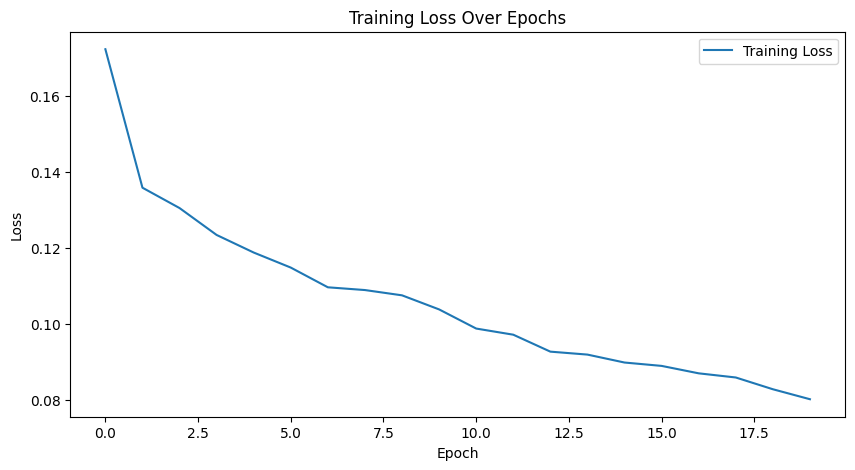

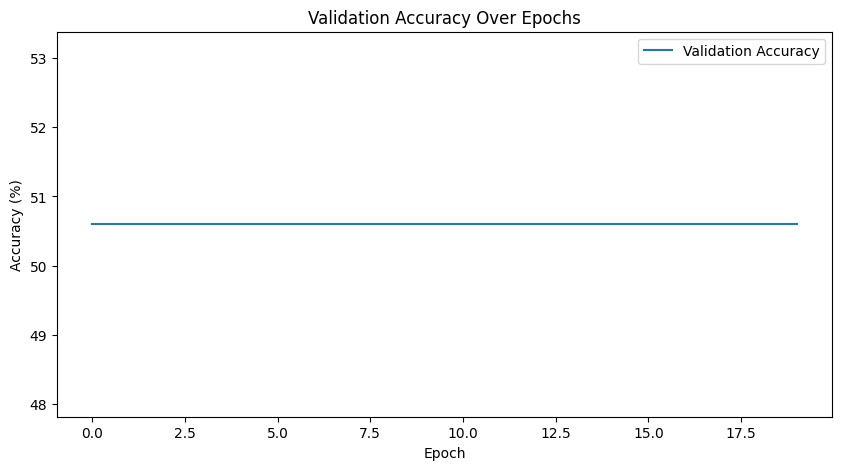

In [32]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the model, optimizer, loss function, and datasets are already defined

def train(EPOCHS):
    model.to(device)
    train_losses = []
    val_accuracies = []

    # Train for EPOCHS
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        for i, (image, label) in enumerate(train_loader):
            image = torch.permute(image, (0,3,1,2)).to(device)
            label = label.unsqueeze(-1).float().to(device)

            optimizer.zero_grad()
            output = model(image)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i % 100) == 0:  # print every 100 steps
                print(f"Epoch {epoch+1}/{EPOCHS}, Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Track loss per epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate on validation set after each epoch
        val_accuracy = get_accuracy(epoch)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot graphs at the end of training
    plot_training_loss(train_losses)
    plot_validation_accuracy(val_accuracies)


def get_accuracy(epoch):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for image, label in val_loader:
            image = torch.permute(image, (0,3,1,2)).to(device)
            label = label.to(device)

            output = model(image)
            _, predicted = torch.max(output, 1)

            total += label.size(0)
            correct += (predicted == label).sum().item()

            all_labels.extend(label.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Calculate precision, recall, F1 score, AUC
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc_score = roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr')

    print(f"Validation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc_score:.4f}")

    # Return accuracy for later plotting
    return accuracy


def plot_training_loss(losses):
    plt.figure(figsize=(10,5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()


def plot_validation_accuracy(accuracies):
    plt.figure(figsize=(10,5))
    plt.plot(accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()


def plot_roc_curve(labels, preds):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)  # Corrected the usage of auc

    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


# Example usage:
train(20)


In [33]:
model.save("mobilenet_model.keras")

AttributeError: 'MobileNet' object has no attribute 'save'